# Multiple output from LSTM model

## Operator 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from keras.optimizers import Adam
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 16})

### Processing functions

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

### LSTM functions

In [4]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []
    mae_list = []

    for i in range(len(y_pred)):
        mae = []
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])
            mae.append(np.abs(y_pred[i][k] - y_true[i][k]))
        mae_list.append(mae)

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.array(mae_list)


def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer=opt)
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    results = {'y_pred': y_pred,
               'y_true': y_true,
               'train_pred': train_pred,
               'train_true': y_train,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results

def box_lookback(results:dict, n_steps_out:int, operator:str):
    sep1 = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ', 'SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ'] 
    comb1 = ['RSRP, SSS_RSRP -> RSRP', 'RSRP, SSS_RSRP -> SSS_RSRP', 'SINR, SSS_SINR -> SINR', 'SINR, SSS_SINR -> SSS_SINR', 'RSRQ, SSS_RSRQ -> RSRQ', 'RSRQ, SSS_RSRQ -> SSS_RSRQ']
    cat2 = ['RSRP, SINR -> RSRP', 'RSRP, SINR -> SINR', 'RSRP, RSRQ -> RSRP', 'RSRP, RSRQ -> RSRQ', 'SINR, RSRQ -> SINR', 'SINR, RSRQ -> RSRQ', 'SSS_RSRP, SSS_SINR -> SSS_RSRP', 'SSS_RSRP, SSS_SINR -> SSS_SINR', 'SSS_RSRP, SSS_RSRQ -> SSS_RSRP', 'SSS_RSRP, SSS_RSRQ -> SSS_RSRQ', 'SSS_SINR, SSS_RSRQ -> SSS_SINR', 'SSS_SINR, SSS_RSRQ -> SSS_RSRQ']
    sep3 = ['RSRP, SINR, RSRQ -> RSRP', 'RSRP, SINR, RSRQ -> SINR', 'RSRP, SINR, RSRQ -> RSRQ', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ']
    comb3 = ['All -> RSRP', 'All -> SINR', 'All -> RSRQ', 'All -> SSS_RSRP', 'All -> SSS_SINR', 'All -> SSS_RSRQ']

    names = ['Cat 1', 'Cat 2', 'Cat 3', 'Cat 4', 'All']

    xncombs = list(results.keys())
    
    maes = [[[] for _ in range(len(names))] for _ in range(len(xncombs))]

    for i in range(len(xncombs)):
        curr_look_back = results[xncombs[i]]
        for key in curr_look_back:
            if key in sep1:
                for j in range(n_steps_out):
                    for k in range(len(curr_look_back[key]['list_mae'][j])):
                        maes[i][0].append(curr_look_back[key]['list_mae'][j][k])
            elif key in comb1:
                for j in range(n_steps_out):
                    for k in range(len(curr_look_back[key]['list_mae'][j])):
                        maes[i][1].append(curr_look_back[key]['list_mae'][j][k])
            elif key in cat2:
                for j in range(n_steps_out):
                    for k in range(len(curr_look_back[key]['list_mae'][j])):
                        maes[i][2].append(curr_look_back[key]['list_mae'][j][k])
            elif key in sep3:
                for j in range(n_steps_out):
                    for k in range(len(curr_look_back[key]['list_mae'][j])):
                        maes[i][3].append(curr_look_back[key]['list_mae'][j][k])
            elif key in comb3:
                for j in range(n_steps_out):
                    for k in range(len(curr_look_back[key]['list_mae'][j])):
                        maes[i][4].append(curr_look_back[key]['list_mae'][j][k])

    flattened_data = []
    for group_index, group in enumerate(maes):
        for category_index, mean_absolute_errors in enumerate(group):
            for mae in mean_absolute_errors:
                flattened_data.append({
                    'Look-back': xncombs[group_index],
                    'Category': names[category_index],
                    'MAE': mae
                })

    df = pd.DataFrame(flattened_data)

    fig = plt.figure(figsize=(10, 5))
    sns.boxplot(x='Look-back', y='MAE', hue='Category', data=df, palette=sns.color_palette('Greens'), gap=0.1, zorder=2, whis=[0, 100])
    plt.grid(zorder=0)
    plt.title(f'{operator}\nMAE by Look-Back and Feature Combination\nLook-ahead is {n_steps_out} time steps')
    plt.legend(ncols=3, loc='upper right')
    plt.tight_layout()
    plt.show()

    return fig

def plot_signal_strengths(df_true, pred, n_steps_in:int, operator:str):
    pred_x = range(n_steps_in, len(pred['RSRP -> RSRP']['y_pred']) + n_steps_in)
    fig, axes = plt.subplots(3, 2, figsize=(10, 13), sharey='row')

    plt.suptitle(f'Predicted and True signal strength values for {operator}', fontweight='semibold')

    axes[0, 0].plot(df_true['RSRP'].values, color=rsrp_colors[2], label='True')
    axes[0, 0].plot(pred_x, pred['RSRP -> RSRP']['y_pred'], color=rsrp_colors[1], label='Predicted')
    axes[0, 0].set_title('RSRP')

    axes[1, 0].plot(df_true['SINR'].values, color=sinr_colors[2], label='True')
    axes[1, 0].plot(pred_x, pred['SINR -> SINR']['y_pred'], color=sinr_colors[1], label='Predicted')
    axes[1, 0].set_title('SINR')

    axes[2, 0].plot(df_true['RSRQ'].values, color=rsrq_colors[3], label='True')
    axes[2, 0].plot(pred_x, pred['RSRQ -> RSRQ']['y_pred'], color=rsrq_colors[1], label='Predicted')
    axes[2, 0].set_title('RSRQ')

    axes[0, 1].plot(df_true['SSS_RSRP'].values, color=rsrp_colors[2], label='True')
    axes[0, 1].plot(pred_x, pred['SSS_RSRP -> SSS_RSRP']['y_pred'], color=rsrp_colors[1], label='Predicted')
    axes[0, 1].set_title('SSS-RSRP')

    axes[1, 1].plot(df_true['SSS_SINR'].values, color=sinr_colors[2], label='True')
    axes[1, 1].plot(pred_x, pred['SSS_SINR -> SSS_SINR']['y_pred'], color=sinr_colors[1], label='Predicted')
    axes[1, 1].set_title('SSS-SINR')

    axes[2, 1].plot(df_true['SSS_RSRQ'].values, color=rsrq_colors[3], label='True')
    axes[2, 1].plot(pred_x, pred['SSS_RSRQ -> SSS_RSRQ']['y_pred'], color=rsrq_colors[1], label='Predicted')
    axes[2, 1].set_title('SSS-RSRQ')

    for ax in axes.flat:
        ax.set_xlim((0, 500))
        ax.set_xticks([])
        ax.set_xlabel('Time')
        leg = ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=2)

        for line in leg.get_lines():
            line.set_linewidth(5.0)
            
    plt.tight_layout()
    plt.show

    return fig

'''
    Plots the mean absolute errors in a boxplot for each signal strength indicator
    Returns a dataframe with mean mae for each timestep for each signal strength indicator
'''
def boxplot_timesteps(results:dict, feature_comb:list, sss_feature_comb:list, n_steps_in:int, n_steps_out:int, operator:str, whiskers=[0, 100], y_lim=None):
    selected_rsrp, selected_sinr, selected_rsrq = feature_comb[0], feature_comb[1], feature_comb[2]
    selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = sss_feature_comb[0], sss_feature_comb[1], sss_feature_comb[2]

    rsrp_lstm, sinr_lstm, rsrq_lstm = results[selected_rsrp]['list_mae'], results[selected_sinr]['list_mae'], results[selected_rsrq]['list_mae']
    sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = results[selected_sss_rsrp]['list_mae'], results[selected_sss_sinr]['list_mae'], results[selected_sss_rsrq]['list_mae']

    rsrp_lstm_mae, sinr_lstm_mae, rsrq_lstm_mae, sss_rsrp_lstm_mae, sss_sinr_lstm_mae, sss_rsrq_lstm_mae = [], [], [], [], [], []
    mean_rsrp, mean_sinr, mean_rsrq, mean_sss_rsrp, mean_sss_sinr, mean_sss_rsrq = [], [], [], [], [], []

    for i in range(n_steps_out):
        rsrp_lstm_mae.append(rsrp_lstm[:, i])
        mean_rsrp.append(round(np.mean(rsrp_lstm[:, i]), 3))

        sinr_lstm_mae.append(sinr_lstm[:, i])
        mean_sinr.append(round(np.mean(sinr_lstm[:, i]), 3))

        rsrq_lstm_mae.append(rsrq_lstm[:, i])
        mean_rsrq.append(round(np.mean(rsrq_lstm[:, i]), 3))

        sss_rsrp_lstm_mae.append(sss_rsrp_lstm[:, i])
        mean_sss_rsrp.append(round(np.mean(sss_rsrp_lstm[:, i]), 3))

        sss_sinr_lstm_mae.append(sss_sinr_lstm[:, i])
        mean_sss_sinr.append(round(np.mean(sss_sinr_lstm[:, i]), 3))

        sss_rsrq_lstm_mae.append(sss_rsrq_lstm[:, i])
        mean_sss_rsrq.append(round(np.mean(sss_rsrq_lstm[:, i]), 3))
    
    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(2, 3, figsize=(10,6), sharey=True)
    sns.boxplot(data=rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[0, 0], whis=whiskers)
    axes[0, 0].set_title('MAE of RSRP')

    sns.boxplot(data=sinr_lstm_mae, color=sinr_colors[2], ax=axes[0, 1], whis=whiskers)
    axes[0, 1].set_title('MAE of SINR')

    sns.boxplot(data=rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[0, 2], whis=whiskers)
    axes[0, 2].set_title('MAE of RSRQ')

    sns.boxplot(data=sss_rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[1, 0], whis=whiskers)
    axes[1, 0].set_title('MAE of SSS-RSRP')

    sns.boxplot(data=sss_sinr_lstm_mae, color=sinr_colors[2], ax=axes[1, 1], whis=whiskers)
    axes[1, 1].set_title('MAE of SSS-SINR')

    sns.boxplot(data=sss_rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[1, 2], whis=whiskers)
    axes[1, 2].set_title('MAE of SSS-RSRQ')

    axes[0, 0].set_ylim((-0.2, y_lim))

    for ax in axes.flat:
        ax.set_ylabel('MAE')
        ax.set_xlabel('Timestep')
        ax.set_xticks(range(n_steps_out))
        ax.set_xticklabels(labels[0:n_steps_out])
        
    plt.suptitle(f'{n_steps_in} steps in, {n_steps_out} steps out\n{operator}', fontsize=16, fontweight='semibold')

    plt.tight_layout()
    plt.show()

    means = {
        'RSRP': mean_rsrp,
        'SINR': mean_sinr,
        'RSRQ': mean_rsrq,
        'SSS-RSRP': mean_sss_rsrp,
        'SSS-SINR': mean_sss_sinr,
        'SSS-RSRQ': mean_sss_rsrq
    }

    means = pd.DataFrame(means, index=labels[0:n_steps_out]).T

    return fig, means

### RF functions

In [67]:
def rf(X_train, X_test, mode_train, mode_test, campaigns:list, test_campaigns:list, features:list, n_steps_in:int, n_steps_out:int, n_estimators=100, max_depth=None, min_samples_leaf=1, preds=[], train_preds__=[]):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])


    rf.fit(X_train_balanced, mode_train_balanced)

    if len(preds) == 0 and len(train_preds) == 0:
        preds_pred = None
        train_preds_pred = None
        if len(test_campaigns) == 1:
            y_pred = rf.predict(X_test[features])

            accuracy = accuracy_score(mode_test['Mode'], y_pred)
            precision = precision_score(mode_test['Mode'], y_pred)
            recall = recall_score(mode_test['Mode'], y_pred)

            y_true = mode_test['Mode']

            train_pred = rf.predict(X_train[features])

            train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
            train_precision = precision_score(mode_train['Mode'], train_pred)
            train_recall = recall_score(mode_train['Mode'], train_pred)

            train_true = mode_train['Mode']
        else:
            X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
            X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
            
            y_pred = rf.predict(X_test_test[features])

            y_pred_total = rf.predict(X_test[features])
            accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
            precision = precision_score(mode_test['Mode'], y_pred_total)
            recall = recall_score(mode_test['Mode'], y_pred_total)

            y_true = X_test_mode['Mode']

            X_train_test = X_train[X_train['campaign'] == campaigns[0]]
            X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

            train_pred = rf.predict(X_train_test[features])

            train_pred_total = rf.predict(X_train[features])
            train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
            train_precision = precision_score(mode_train['Mode'], train_pred_total)
            train_recall = recall_score(mode_train['Mode'], train_pred_total)

            train_true = X_train_mode['Mode']

        pred_accuracy, pred_recall, pred_precision = 0, 0, 0
        train_pred_accuracy, train_pred_recall, train_pred_precision = 0, 0, 0

    else:
        _, y_true = series_split_sequences(X_test, mode_test['Mode'], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, test_seq = series_split_sequences(X_test, X_test[features], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, train_true = series_split_sequences(X_train, mode_train['Mode'], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, train_seq = series_split_sequences(X_train, X_train[features], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        y_pred = []
        preds_pred = []
        train_preds = []
        train_preds_pred = []

        for i in range(len(test_seq)):
            pred = rf.predict(test_seq[i])
            y_pred.append(pred)
        
        for i in range(len(preds)):
            row = preds.iloc[i]
            row = pd.DataFrame(row.values.tolist(), index=row.index).transpose()
            pred = rf.predict(row)
            preds_pred.append(pred)

        for i in range(len(train_seq)):
            pred = rf.predict(train_seq[i])
            train_preds.append(pred)
        
        for i in range(len(train_preds__)):
            row = train_preds__.iloc[i]
            row = pd.DataFrame(row.values.tolist(), index=row.index).transpose()
            pred = rf.predict(row)
            train_preds_pred.append(pred)
        
        accuracy, recall, precision = metrics(y_true, y_pred)
        train_accuracy, train_recall, train_precision = metrics(train_true, train_preds)
        pred_accuracy, pred_recall, pred_precision = metrics(y_true, preds_pred)
        train_pred_accuracy, train_pred_recall, train_pred_precision = metrics(train_true, train_preds_pred)

    acc = []
    pred_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(np.array(y_true)[:, i], np.array(y_pred)[:, i]))
        pred_acc.append(accuracy_score(np.array(y_true)[:, i], np.array(preds_pred)[:, i]))
    
    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'pred_pred': preds_pred,
               'train_true': train_true,
               'train_pred': train_preds,
               'train_pred_pred':  train_preds_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_pred': round(pred_accuracy, 3),
               'Precision_pred': round(pred_recall, 3),
               'Recall_pred': round(pred_precision, 3),
               'Accuracy_train_pred': round(train_pred_accuracy, 3),
               'Recall_train_pred': round(train_pred_recall, 3),
               'Precision_train_pred': round(train_pred_precision, 3),
               'Accuracy_list': acc,
               'Accuracy_pred_list': pred_acc,
               'model': rf}
    return results

def plot_mode(pred, true, preds, operator:str, comb:str, colors=mode_colors):
    fig = plt.figure(figsize=(11, 6))
    plt.plot(preds, color=colors[0], label='Predicted on predicted values', zorder=1)
    plt.plot(np.array(pred) + 2, color=colors[1], label='Predicted on true values', zorder=2)
    plt.plot(np.array(true) + 4, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 6))
    plt.yticks([0, 1, 2, 3, 4, 5], ['4G', '5G', '4G', '5G', '4G', '5G'])
    plt.title(f'{operator}\nParameters: {comb}')
    plt.legend(ncols=3, loc='best')
    plt.tight_layout()
    plt.show()

    return fig

'''
    Plots the accuracy for each timestep ahead for test and pred
'''
def boxplot_accuracies(results:dict, n_steps_out:str, n_steps_in:str, whiskers=[0, 100]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_pred = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_pred[i].append(results[key]['Accuracy_pred_list'][i])
    
    df_combined = pd.DataFrame(columns=['Accuracy', 'Timestep', 'Values'])
    for i in range(n_steps_out):
        for acc in accuracy[i]:
            new_row = {'Accuracy': acc, 'Timestep': i, 'Values': 'Test'}
            df_combined = pd.concat([df_combined, pd.DataFrame([new_row])], ignore_index=True)
        for acc in accuracy_pred[i]:
            new_row = {'Accuracy': acc, 'Timestep': i, 'Values': 'Predicted'}
            df_combined = pd.concat([df_combined, pd.DataFrame([new_row])], ignore_index=True)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig = plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_combined, x='Timestep', y='Accuracy', hue='Values', palette=[sns.color_palette('Greens')[1], sns.color_palette('Greens')[3]], whis=whiskers, zorder=2)
    plt.title(f'Accuracy per time step with look-back of {n_steps_in}')
    plt.ylabel('Accuracy')
    plt.xlabel('Steps ahead')
    plt.xticks(range(n_steps_out), labels[0:n_steps_out])
    plt.grid(zorder=0)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return fig

### Overlapping campaigns

* Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi, Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode, Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi

* Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel, Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel

* Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2, Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode

* Ping_UNIDATA_4G5G_TIM_Driving_Luca, Interactivity_gaming_4G5G_TIM_Driving_Luca, Capacity_Ookla_4G5G_Tim_Driving_Luca

### Parameters

In [6]:
tf.random.set_seed(4567)
op1_dataset = 'datasets/Op1_merged.csv'
operator = 'Operator 1'

In [7]:
overlap_1 = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi', 
             'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
             'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

overlap_2 = ['Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel', 
             'Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel']

overlap_3 = ['Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2', 
             'Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode']

overlap_4 = ['Ping_UNIDATA_4G5G_TIM_Driving_Luca', 
             'Interactivity_gaming_4G5G_TIM_Driving_Luca', 
             'Capacity_Ookla_4G5G_Tim_Driving_Luca']

In [8]:
op1_overlap = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

test = read_dataset(op1_dataset, campaigns=[op1_overlap[0]])
train = read_dataset(op1_dataset, campaigns=op1_overlap[1:4])

route_to_add = read_dataset(op1_dataset, campaigns=[op1_overlap[4]])
train = pd.concat([route_to_add[5400::], train])
train.reset_index(drop=True, inplace=True)

route_to_add = read_dataset(op1_dataset, campaigns=[op1_overlap[5]])
train = pd.concat([route_to_add[0:1180], train])
train.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [9]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                    #  ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                    #  ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                    #  ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                    #  ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ']]#, 
                    #  ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

## Testing n units for m layers

In [10]:
# parameters
n_steps_in = 2
n_steps_out = 5
units = [[5, 5], [5, 10], [10, 10], [5, 5, 5], [5, 5, 10], [5, 10, 5], [10, 5, 5], [5, 10, 10], [10, 5, 10], [10, 10, 5], [10, 10, 10], [10, 20, 10], [5, 5, 5, 5], [10, 10, 10, 10]]
features = ['RSRP', 'SSS_RSRP']
 
results = {}

for unit in units:
    layers = ' ->'.join(map(str, unit))
    warnings.simplefilter(action='ignore')
    features.extend(['campaign'])
    results[layers] = long_short_term_memory(train=train[features], test=test[features], target_feature='RSRP', features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=unit)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,5 ->5,0.00919,0.00684,3.14,3.47
1,5 ->10,0.00811,0.00505,2.16,2.64
2,10 ->10,0.00423,0.00248,0.95,1.24
3,5 ->5 ->5,0.01306,0.00523,1.45,2.44
4,5 ->5 ->10,0.00782,0.00597,2.65,2.95
5,5 ->10 ->5,0.00890,0.00651,2.77,3.15
6,10 ->5 ->5,0.01102,0.00423,1.34,2.04
7,5 ->10 ->10,0.00435,0.00475,2.16,2.34
8,10 ->5 ->10,0.00527,0.00651,3.08,3.11
9,10 ->10 ->5,0.00933,0.00342,1.46,1.98


## One step prediction

In [11]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']
units = [10, 10]

In [12]:
n_steps_ins, n_steps_out = [1, 2, 5], 1

lstm_results_1step = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            if features.__contains__(target):
                used_features = ''
                if len(features) == 6:
                    used_features = 'All'
                else:
                    used_features = ', '.join(features)
                used_features = used_features + ' -> ' + target
                features.append('campaign')
                warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
                temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    lstm_results_1step[f'x:{n_steps_in}'] = temp_results


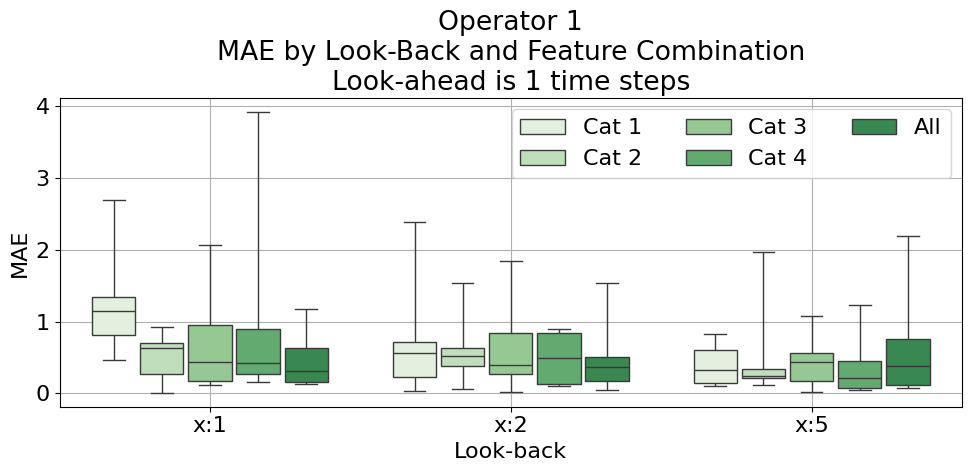

In [13]:
fig = box_lookback(lstm_results_1step, n_steps_out=1, operator=operator)
fig.savefig(r'../latex/plots/lstm_reg/op1_box_mae_look-back_n1.pdf')

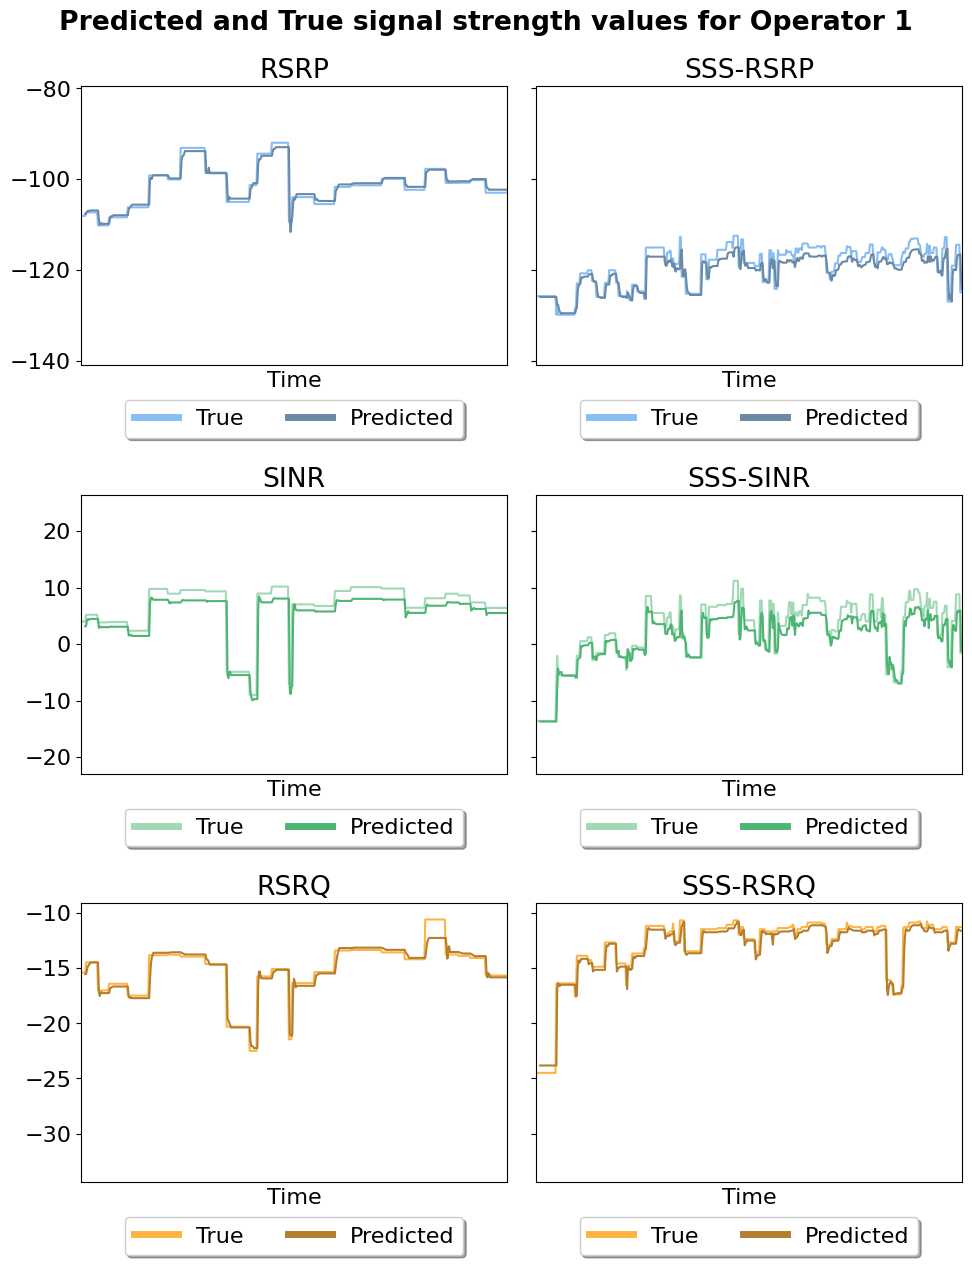

In [14]:
fig = plot_signal_strengths(df_true=test, pred=lstm_results_1step['x:5'], n_steps_in=5, operator=operator)
fig.savefig(r'../latex/plots/lstm_reg/op1_signal_values.pdf')

### Random Forest

In [63]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']
op1_lstm_results = lstm_results_1step['x:5']

op1_lstm_preds = pd.DataFrame({'RSRP': op1_lstm_results[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': op1_lstm_results[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': op1_lstm_results[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': op1_lstm_results[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': op1_lstm_results[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': op1_lstm_results[sss_feature_comb[2]]['y_pred'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'])

op1_lstm_pred_train = pd.DataFrame({'RSRP': op1_lstm_results[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': op1_lstm_results[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': op1_lstm_results[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': op1_lstm_results[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': op1_lstm_results[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': op1_lstm_results[sss_feature_comb[2]]['train_pred'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'])

In [64]:
est_try = [5, 10, 50, 100, 120, 150, 200]
min_leaf_size = [1, 5, 10, 15]

In [65]:
rf_results_1step = {}
feats = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feats.append('campaign')
features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results_1step[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, preds=op1_lstm_preds, train_preds__=op1_lstm_pred_train, n_steps_in=5, n_steps_out=1)

df_rf_results = pd.DataFrame.from_dict(rf_results_1step, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred', 'Accuracy_list', 'Accuracy_pred_list'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred
0,"n_est: 5, min_leaf: 1",0.685,0.780,0.418,0.997,0.992,0.996,0.646,0.376,0.699,0.850,0.736,0.649
1,"n_est: 5, min_leaf: 5",0.627,0.679,0.326,0.992,0.978,0.988,0.594,0.286,0.605,0.840,0.756,0.620
2,"n_est: 5, min_leaf: 10",0.640,0.703,0.347,0.983,0.943,0.984,0.634,0.339,0.694,0.855,0.801,0.644
3,"n_est: 5, min_leaf: 15",0.635,0.695,0.340,0.976,0.917,0.983,0.614,0.309,0.652,0.841,0.789,0.618
4,"n_est: 10, min_leaf: 1",0.629,0.696,0.313,0.998,0.993,0.997,0.613,0.285,0.665,0.874,0.739,0.716
5,"n_est: 10, min_leaf: 5",0.616,0.662,0.302,0.993,0.976,0.993,0.618,0.308,0.665,0.846,0.789,0.627
6,"n_est: 10, min_leaf: 10",0.631,0.698,0.322,0.987,0.957,0.988,0.633,0.331,0.695,0.846,0.774,0.630
7,"n_est: 10, min_leaf: 15",0.645,0.712,0.358,0.979,0.931,0.981,0.641,0.348,0.708,0.862,0.822,0.656
8,"n_est: 50, min_leaf: 1",0.629,0.698,0.314,0.998,0.994,0.997,0.622,0.301,0.685,0.872,0.800,0.686
9,"n_est: 50, min_leaf: 5",0.657,0.752,0.355,0.995,0.984,0.994,0.629,0.322,0.691,0.873,0.810,0.686


In [68]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.643
Mean precision: 0.719
Mean recall: 0.342


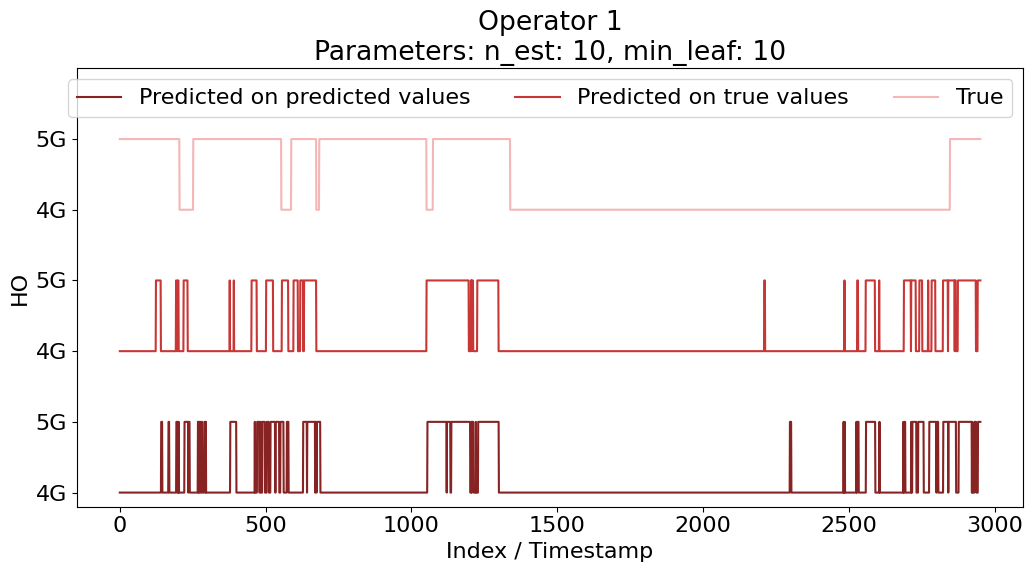

In [69]:
comb = 'n_est: 10, min_leaf: 10'
combination = rf_results_1step[comb]
y_true = combination['y_true']
y_pred = combination['y_pred']
pred_pred = combination['pred_pred']
fig = plot_mode(pred=y_pred, true=y_true, preds=pred_pred, operator=operator, comb=comb)
fig.savefig(r'../latex/plots/rf/op1_x5n1.pdf')

## 2 steps prediction

In [19]:
# n_steps_ins, n_steps_out = [1, 2, 5], 2

# lstm_results_2step = {}

# for n_steps_in in n_steps_ins:
#     temp_results = {}
#     for target in target_features:
#         for features in feature_selection:
#             if features.__contains__(target):
#                 used_features = ''
#                 if len(features) == 6:
#                     used_features = 'All'
#                 else:
#                     used_features = ', '.join(features)
#                 used_features = used_features + ' -> ' + target
#                 features.append('campaign')
#                 warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
#                 temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
#     lstm_results_2step[f'x:{n_steps_in}'] = temp_results

In [20]:
# fig = box_lookback(lstm_results_2step, n_steps_out=2, operator=operator)
# fig.savefig(r'../latex/plots/lstm_reg/op1_box_mae_look-back_n2.pdf')

In [21]:
# fig, mae_each_step = boxplot_timesteps(results=lstm_results_2step['x:5'], feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=5, n_steps_out=2, operator=operator)
# fig.savefig(r'../latex/plots/lstm_reg/op1_box_look-ahead_n2_mae_x5.pdf')

In [22]:
# fig, mae_each_step = boxplot_timesteps(results=lstm_results_2step['x:5'], feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=5, n_steps_out=2, operator=operator, y_lim=6)
# fig.savefig(r'../latex/plots/lstm_reg/op2_box_2_steps_mae_zoom.pdf')

In [23]:
# mae_each_step

## 3 Steps Prediction

In [24]:
n_steps_ins, n_steps_out = [1, 3, 5], 3

lstm_results_3step = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            if features.__contains__(target):
                used_features = ''
                if len(features) == 6:
                    used_features = 'All'
                else:
                    used_features = ', '.join(features)
                used_features = used_features + ' -> ' + target
                features.append('campaign')
                warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
                temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    lstm_results_3step[f'x:{n_steps_in}'] = temp_results

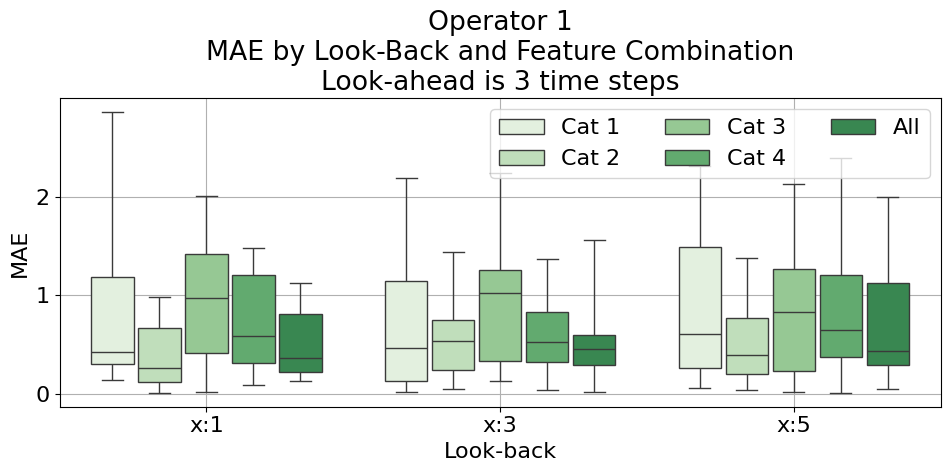

In [25]:
fig = box_lookback(lstm_results_3step, n_steps_out=3, operator=operator)
fig.savefig(r'../latex/plots/lstm_reg/op1_box_mae_look-back_n3.pdf')

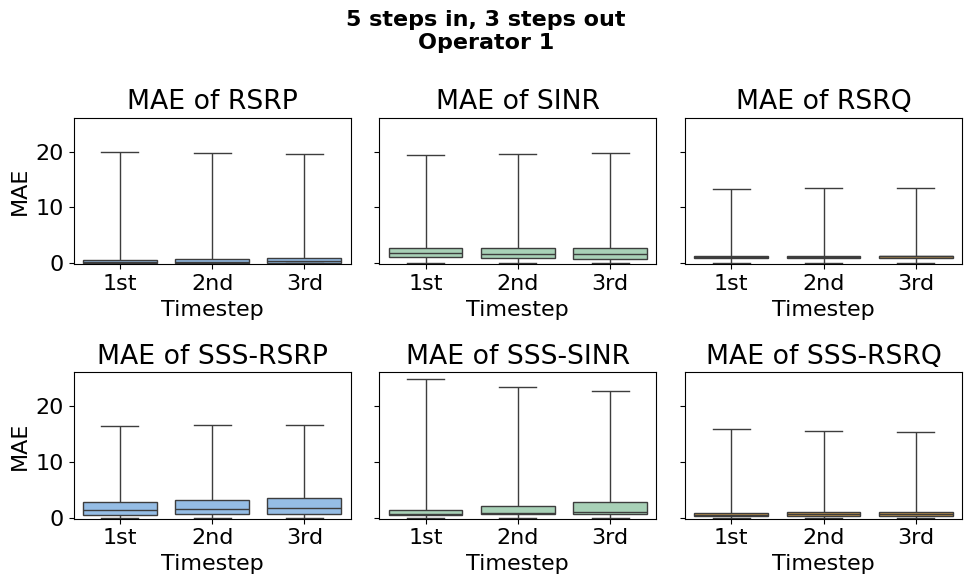

In [26]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_3step['x:5'], feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=5, n_steps_out=3, operator=operator)
fig.savefig(r'../latex/plots/lstm_reg/op1_box_3_steps_mae.pdf')

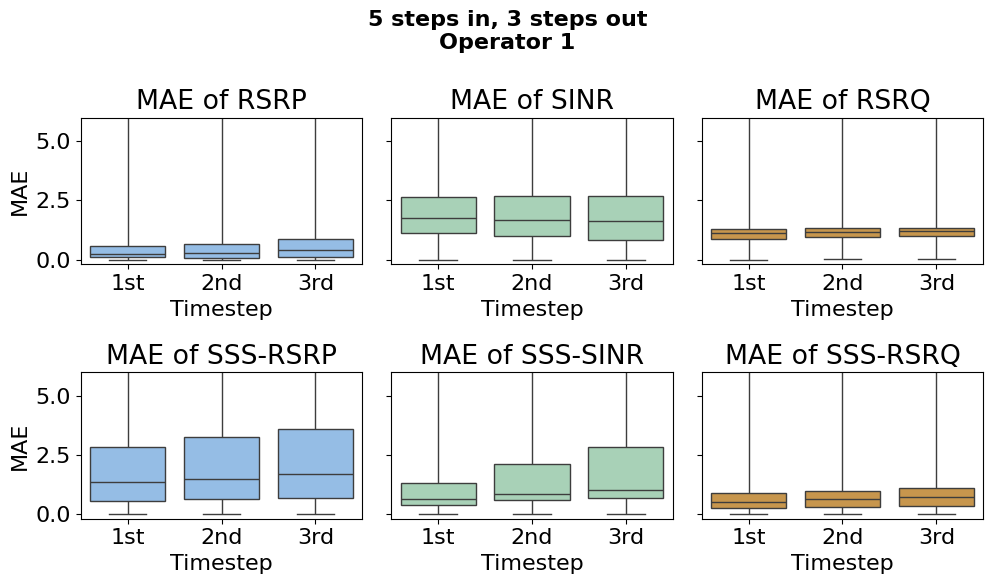

In [27]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_3step['x:5'], feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=5, n_steps_out=3, operator=operator, y_lim=6)
fig.savefig(r'../latex/plots/lstm_reg/op1_box_3_steps_mae_zoom.pdf')

In [28]:
mae_each_step

,1st,2nd,3rd
RSRP,0.566,0.753,0.969
SINR,2.130,2.139,2.132
RSRQ,1.100,1.190,1.280
SSS-RSRP,1.988,2.266,2.539
SSS-SINR,1.247,1.771,2.162
SSS-RSRQ,0.695,0.873,1.038


### Random Forest

In [52]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']
op1_lstm_results = lstm_results_3step['x:5']

op1_lstm_preds = pd.DataFrame({'RSRP': op1_lstm_results[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': op1_lstm_results[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': op1_lstm_results[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': op1_lstm_results[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': op1_lstm_results[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': op1_lstm_results[sss_feature_comb[2]]['y_pred'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'])

op1_lstm_pred_train = pd.DataFrame({'RSRP': op1_lstm_results[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': op1_lstm_results[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': op1_lstm_results[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': op1_lstm_results[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': op1_lstm_results[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': op1_lstm_results[sss_feature_comb[2]]['train_pred'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'])

In [53]:
rf_results = {}
feats = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feats.append('campaign')
features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, preds=op1_lstm_preds, train_preds__=op1_lstm_pred_train, n_steps_in=5, n_steps_out=3)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred', 'Accuracy_list', 'Accuracy_pred_list'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred
0,"n_est: 5, min_leaf: 1",0.633,0.698,0.328,0.998,0.994,0.996,0.654,0.336,0.763,0.828,0.706,0.602
1,"n_est: 5, min_leaf: 5",0.627,0.678,0.329,0.992,0.974,0.993,0.649,0.343,0.740,0.826,0.715,0.596
2,"n_est: 5, min_leaf: 10",0.654,0.736,0.363,0.988,0.959,0.988,0.666,0.381,0.757,0.837,0.727,0.619
3,"n_est: 5, min_leaf: 15",0.677,0.734,0.443,0.982,0.940,0.983,0.653,0.370,0.724,0.823,0.726,0.588
4,"n_est: 10, min_leaf: 1",0.632,0.706,0.312,0.998,0.994,0.996,0.640,0.340,0.709,0.836,0.695,0.623
5,"n_est: 10, min_leaf: 5",0.657,0.752,0.357,0.994,0.979,0.993,0.670,0.378,0.774,0.834,0.721,0.613
6,"n_est: 10, min_leaf: 10",0.644,0.716,0.348,0.987,0.957,0.988,0.648,0.365,0.713,0.841,0.768,0.621
7,"n_est: 10, min_leaf: 15",0.642,0.709,0.347,0.984,0.946,0.985,0.653,0.363,0.732,0.821,0.779,0.578
8,"n_est: 50, min_leaf: 1",0.649,0.744,0.339,0.998,0.994,0.997,0.649,0.348,0.733,0.849,0.717,0.652
9,"n_est: 50, min_leaf: 5",0.654,0.745,0.351,0.995,0.983,0.994,0.658,0.369,0.743,0.835,0.736,0.612


In [54]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.648
Mean precision: 0.724
Mean recall: 0.352


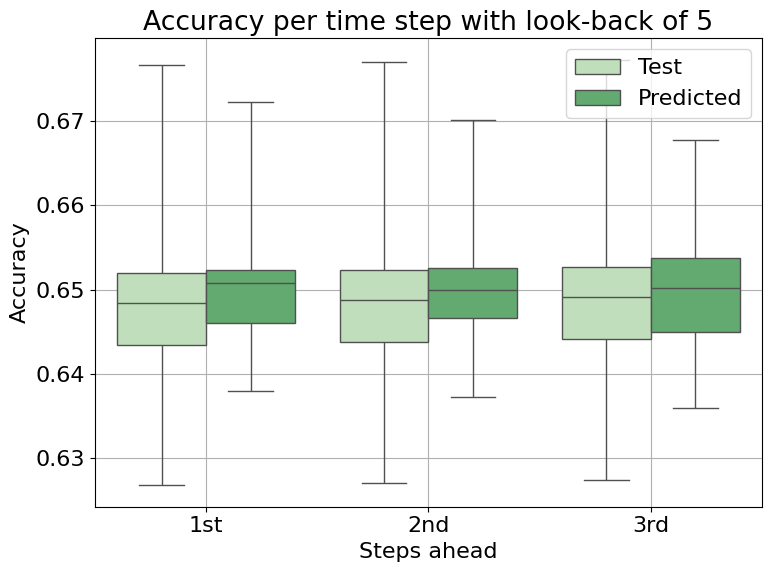

In [ ]:
fig = boxplot_accuracies(rf_results, n_steps_out=3, n_steps_in=5)
# fig.savefig(r'../latex/plots/rf/op1_x5n3.pdf')

## 5 Steps Prediction

In [32]:
n_steps_ins, n_steps_out = [2, 5, 8], 5

lstm_results_5step = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            if features.__contains__(target):
                used_features = ''
                if len(features) == 6:
                    used_features = 'All'
                else:
                    used_features = ', '.join(features)
                used_features = used_features + ' -> ' + target
                features.append('campaign')
                warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
                temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    lstm_results_5step[f'x:{n_steps_in}'] = temp_results

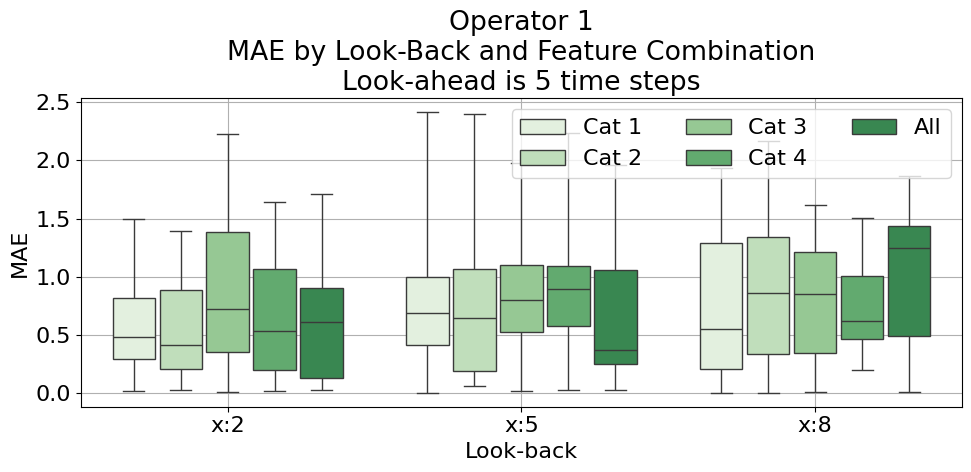

In [33]:
fig = box_lookback(lstm_results_5step, n_steps_out=5, operator=operator)
fig.savefig(r'../latex/plots/lstm_reg/op1_box_mae_look-back_n5.pdf')

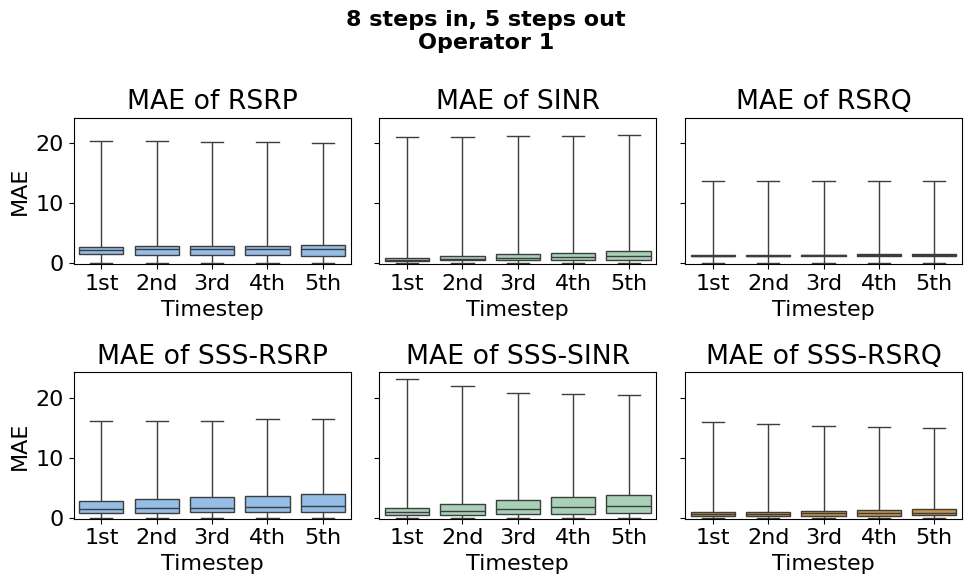

In [34]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_5step['x:8'], feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=8, n_steps_out=5, operator=operator)
fig.savefig(r'../latex/plots/lstm_reg/op1_box_5_steps_mae.pdf')

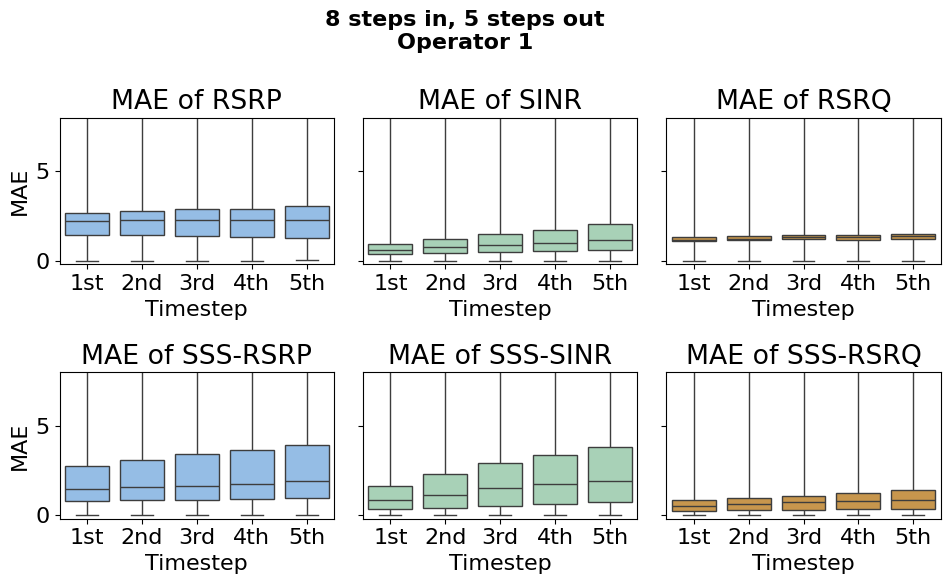

In [35]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_5step['x:8'], feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=8, n_steps_out=5, operator=operator, y_lim=8)
fig.savefig(r'../latex/plots/lstm_reg/op1_box_5_steps_mae_zoom.pdf')

In [36]:
mae_each_step

,1st,2nd,3rd,4th,5th
RSRP,2.142,2.284,2.398,2.479,2.591
SINR,1.037,1.279,1.487,1.667,1.835
RSRQ,1.204,1.298,1.398,1.468,1.548
SSS-RSRP,2.034,2.274,2.496,2.687,2.858
SSS-SINR,1.422,1.852,2.228,2.537,2.779
SSS-RSRQ,0.691,0.861,1.014,1.147,1.267


### Random Forest

In [56]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']
op1_lstm_results = lstm_results_5step['x:8']

op1_lstm_preds = pd.DataFrame({'RSRP': op1_lstm_results[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': op1_lstm_results[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': op1_lstm_results[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': op1_lstm_results[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': op1_lstm_results[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': op1_lstm_results[sss_feature_comb[2]]['y_pred'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'])

op1_lstm_pred_train = pd.DataFrame({'RSRP': op1_lstm_results[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': op1_lstm_results[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': op1_lstm_results[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': op1_lstm_results[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': op1_lstm_results[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': op1_lstm_results[sss_feature_comb[2]]['train_pred'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'])

In [57]:
rf_results = {}
feats = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feats.append('campaign')
features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, preds=op1_lstm_preds, train_preds__=op1_lstm_pred_train, n_steps_in=8, n_steps_out=5)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred', 'Accuracy_list', 'Accuracy_pred_list'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred
0,"n_est: 5, min_leaf: 1",0.644,0.710,0.354,0.997,0.993,0.994,0.639,0.347,0.700,0.822,0.778,0.579
1,"n_est: 5, min_leaf: 5",0.643,0.734,0.322,0.992,0.974,0.992,0.648,0.347,0.726,0.838,0.760,0.614
2,"n_est: 5, min_leaf: 10",0.649,0.712,0.368,0.985,0.950,0.985,0.664,0.421,0.714,0.814,0.797,0.561
3,"n_est: 5, min_leaf: 15",0.666,0.738,0.400,0.978,0.924,0.983,0.640,0.357,0.694,0.823,0.770,0.582
4,"n_est: 10, min_leaf: 1",0.622,0.693,0.288,0.998,0.993,0.997,0.620,0.315,0.663,0.844,0.765,0.625
5,"n_est: 10, min_leaf: 5",0.666,0.789,0.350,0.993,0.976,0.994,0.643,0.362,0.699,0.838,0.760,0.614
6,"n_est: 10, min_leaf: 10",0.650,0.726,0.354,0.988,0.958,0.990,0.620,0.322,0.659,0.826,0.796,0.584
7,"n_est: 10, min_leaf: 15",0.634,0.689,0.341,0.982,0.939,0.982,0.618,0.303,0.665,0.821,0.793,0.575
8,"n_est: 50, min_leaf: 1",0.643,0.715,0.343,0.998,0.994,0.997,0.641,0.361,0.693,0.846,0.786,0.625
9,"n_est: 50, min_leaf: 5",0.646,0.727,0.341,0.995,0.984,0.994,0.626,0.328,0.673,0.833,0.761,0.603


In [58]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.649
Mean precision: 0.727
Mean recall: 0.349


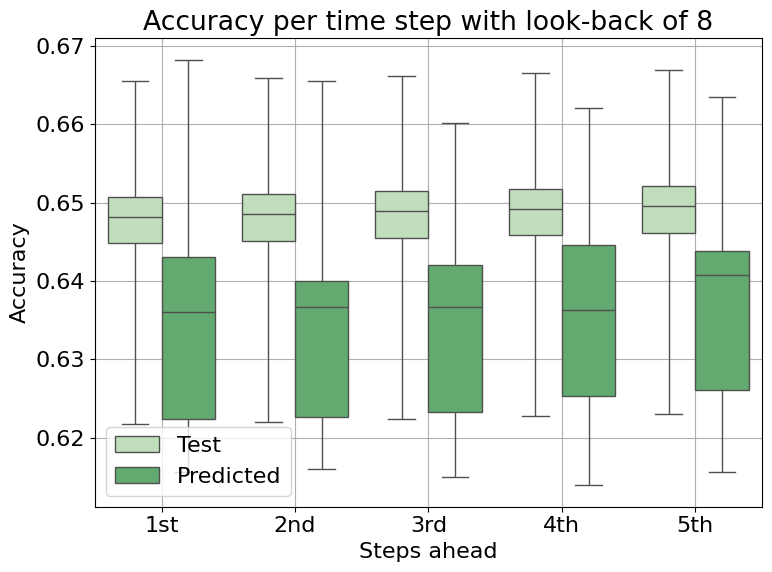

In [ ]:
fig = boxplot_accuracies(rf_results, n_steps_out=5, n_steps_in=8)
# fig.savefig(r'../latex/plots/rf/op1_x8n5.pdf')

## 10 Steps Prediction

In [60]:
# n_steps_ins, n_steps_out = [2, 5, 10, 15], 10

# lstm_results_10step = {}

# for n_steps_in in n_steps_ins:
#     temp_results = {}
#     for target in target_features:
#         for features in feature_selection:
#             if features.__contains__(target):
#                 used_features = ''
#                 if len(features) == 6:
#                     used_features = 'All'
#                 else:
#                     used_features = ', '.join(features)
#                 used_features = used_features + ' -> ' + target
#                 features.append('campaign')
#                 warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
#                 temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
#     lstm_results_10step[f'x:{n_steps_in}'] = temp_results

In [61]:
# fig = box_lookback(lstm_results_10step, n_steps_out=10, operator=operator)
# fig.savefig(r'../latex/plots/lstm_reg/op1_box_mae_look-back_n10.pdf')

In [62]:
# fig, mae_each_step = boxplot_timesteps(results=lstm_results_10step['x:15'], feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=15, n_steps_out=10, operator=operator)
# fig.savefig(r'../latex/plots/lstm/op2_box_10_steps_mae.pdf')